In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dpzbf2ab
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dpzbf2ab
  Resolved https://github.com/albumentations-team/albumentations to commit 9b0525f479509195a7a7b7c19311d8e63bbc6494
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import os

from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation'
#Augmentations 
train_augs = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees = (-20, 20)),
    T.ToTensor()       #changes dimension from (height, width, channel) to (channel, width, height)
])                                         #to prevent overfitting

valid_augs = T.Compose([T.ToTensor()])

In [ ]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, valid_augs)

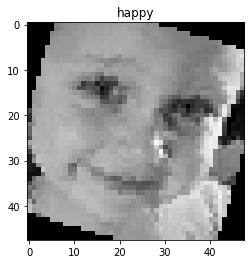

In [ ]:
def print_random_image(trainset):
  random.seed(60)
  rand_idx = random.random()
  rand_idx = rand_idx * len(trainset)

  image, label = trainset[int(rand_idx)]
  plt.imshow(image.permute(1, 2, 0)) # changing tensor format back for printing

  for idx, emotion in enumerate(trainset.class_to_idx.keys()):
    if idx == label:
      label = emotion
    plt.title(label)
  plt.show()

print_random_image(trainset)

In [ ]:
from pickle import TRUE
# loading data
DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 50

from torch.utils.data import DataLoader

trainloader = DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = TRUE)
validloader = DataLoader(dataset = validset, batch_size = BATCH_SIZE)

for images, labels in trainloader: #fetching just one batch of images and labels; trainloader not subscriptable
  break

In [ ]:
import timm
from torch import nn
#the shizz

class FaceModel(nn.Module):
  def __init__(self) -> None:
    super(FaceModel, self).__init__()

    self.eff_net = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 7)  # the model

  def forward(self, image, labels = None):
    logits = self.eff_net(image)

    if labels is not None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss

    return logits

In [ ]:
#model usage
model = FaceModel()
model.to(DEVICE)

In [ ]:
from tqdm import tqdm

def multiclass_accuracy(y_pred, y_true):
  top_p, top_class = y_pred.topk(1, dim = 1)
  equals = top_class == y_true.view(*top_class.shape)
  return torch.mean(equals.type(torch.FloatTensor))

def training_fn(model, dataloader, optimizer, curr_epo):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  token = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(curr_epo + 1) + "/" + str(EPOCHS))
  
  for t, data in enumerate(token):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    token.set_postfix({'loss' : '%f' %float(total_loss/(t+1)), 'acc' : '%f' %float(total_acc/(t+1))})

  return total_loss/len(dataloader), total_acc/len(dataloader)

  

In [ ]:
def eval_fn(model, dataloader, curr_epo):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    token = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(curr_epo + 1) + "/" + str(EPOCHS))
  
    for t, data in enumerate(token):
       images, labels = data
       images, labels = images.to(DEVICE), labels.to(DEVICE)

       logits, loss = model(images, labels)

       total_loss += loss.item()
       total_acc += multiclass_accuracy(logits, labels)
       token.set_postfix({'loss' : '%f' %float(total_loss/(t+1)), 'acc' : '%f' %float(total_acc/(t+1))})

    return total_loss/len(dataloader), total_acc/len(dataloader)

In [ ]:
#Training loop

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

best_valid_loss = np.Inf

for i in range(EPOCHS):
  training_loss, training_acc = training_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)
  
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_weights.pt') #saving the parameters of the best iteration yet
    print("Saved best weights")
    best_valid_loss = valid_loss 

